In [9]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:

# Load LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Extract data and labels
X = lfw_people.images
y = lfw_people.target

# Get the names of the people (classes)
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

# Print dataset information
print("Total dataset size:")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1] * X.shape[2]}")
print(f"Number of classes: {n_classes}")

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

# Reshape images to match VGG16 input shape (224x224x3)
X_train = np.stack([np.stack([X_train[i]] * 3, axis=-1) for i in range(X_train.shape[0])], axis=0)
X_test = np.stack([np.stack([X_test[i]] * 3, axis=-1) for i in range(X_test.shape[0])], axis=0)

# Resize images to 224x224 (required for VGG16)
X_train = tf.image.resize(X_train, (224, 224))
X_test = tf.image.resize(X_test, (224, 224))

Total dataset size:
Number of samples: 1288
Number of features: 1850
Number of classes: 7


2025-03-20 22:03:32.862197: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-20 22:03:32.886601: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/vinoth/.local/lib/python3.10/site-packages/cv2/../../lib64:/home/vinoth/ros2_ws/install/my_cpp_library/lib:/home/vinoth/ros2_ws/install/diffdrive_arduino/lib:/home/vinoth/ros2_ws/install/custom_costmap_layer/lib:/opt/ros/humble/opt/zenoh_cpp_vendor/lib:/usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib:/home/vinoth/.mujoco/mujoco210/bin:/usr/lib/nvidia
2025-03-20 22:03:32.886626: W tensorflow/core/common_runtime/g

In [4]:
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

# Load VGG16 model pre-trained on ImageNet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Preprocess the images for VGG16
X_train_vgg = preprocess_input(X_train)
X_test_vgg = preprocess_input(X_test)

# Extract features
train_features = base_model.predict(X_train_vgg)
test_features = base_model.predict(X_test_vgg)

# Flatten the features
train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 70s 1us/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step


In [8]:
# Train Logistic Regression
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(train_features_flat, y_train)

# Train Random Forest
clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf.fit(train_features_flat, y_train)

# Train KNN
clf_knn = KNeighborsClassifier(n_neighbors=5)
clf_knn.fit(train_features_flat, y_train)

# Predict and evaluate
lr_predictions = clf_lr.predict(test_features_flat)
rf_predictions = clf_rf.predict(test_features_flat)
knn_predictions = clf_knn.predict(test_features_flat)

In [10]:
def evaluate_classifier(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Performance Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("-" * 40)

# Evaluate Logistic Regression
evaluate_classifier(y_test, lr_predictions, "Logistic Regression")

# Evaluate Random Forest
evaluate_classifier(y_test, rf_predictions, "Random Forest")

# Evaluate KNN
evaluate_classifier(y_test, knn_predictions, "KNN")

Performance Metrics for Logistic Regression:
Accuracy: 0.4534
Precision: 0.2056
Recall: 0.4534
F1-Score: 0.2829
----------------------------------------
Performance Metrics for Random Forest:
Accuracy: 0.6304
Precision: 0.7466
Recall: 0.6304
F1-Score: 0.5613
----------------------------------------
Performance Metrics for KNN:
Accuracy: 0.5559
Precision: 0.5539
Recall: 0.5559
F1-Score: 0.5403
----------------------------------------


/home/vinoth/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/home/vinoth/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


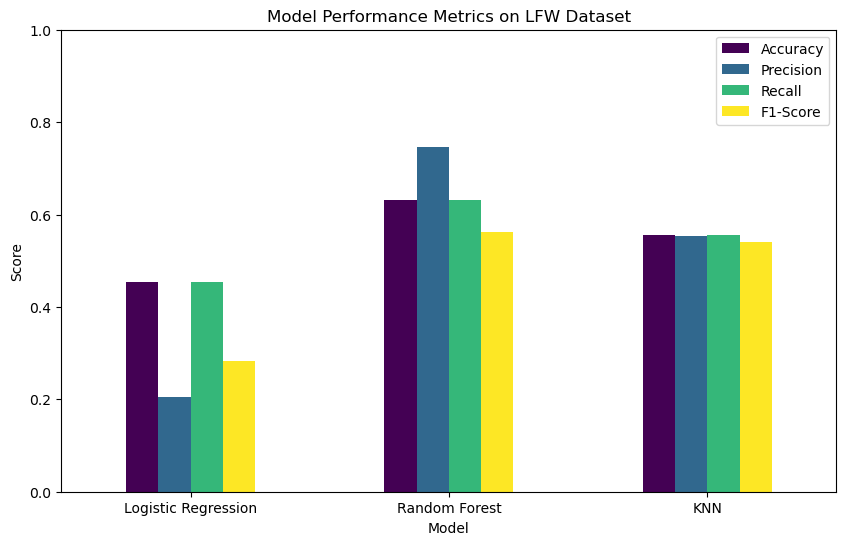

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame to store metrics
metrics = {
    "Model": ["Logistic Regression", "Random Forest", "KNN"],
    "Accuracy": [accuracy_score(y_test, lr_predictions),
                 accuracy_score(y_test, rf_predictions),
                 accuracy_score(y_test, knn_predictions)],
    "Precision": [precision_score(y_test, lr_predictions, average='weighted'),
                  precision_score(y_test, rf_predictions, average='weighted'),
                  precision_score(y_test, knn_predictions, average='weighted')],
    "Recall": [recall_score(y_test, lr_predictions, average='weighted'),
               recall_score(y_test, rf_predictions, average='weighted'),
               recall_score(y_test, knn_predictions, average='weighted')],
    "F1-Score": [f1_score(y_test, lr_predictions, average='weighted'),
                 f1_score(y_test, rf_predictions, average='weighted'),
                 f1_score(y_test, knn_predictions, average='weighted')]
}

df_metrics = pd.DataFrame(metrics)

# Plot the metrics
df_metrics.set_index("Model").plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Model Performance Metrics on LFW Dataset")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.show()